In [1]:
# 单细胞转录组（scRNA-seq）多样本处理流水线（基于 Scanpy）
# 文件名: scRNA_multi_sample_pipeline.py
# 说明：
#  - 支持读取多份 10x 或 h5/mtx 数据（也可修改为读取其他格式）
#  - 包含 QC、过滤、归一化、寻找高变基因、降维、聚类、差异分析
#  - 提供两种批次整合选择（Harmony 或 BBKNN），可按需启用
# 依赖：scanpy, anndata, matplotlib, seaborn, numpy, pandas
# （可选）scrublet 用于双细胞检测；harmony-pytorch 或 harmonypy 用于 Harmony；bbknn 可选

import os
import glob
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------- 配置 -----------------------------
# 数据目录，每个样本放在单独子文件夹（例如 10x 的输出）
DATA_DIR = './data'  # 修改为你的数据父目录
# 支持的样本文件夹模式（每个子文件夹内为 10x 的 filtered_feature_bc_matrix 或 h5 文件）
SAMPLE_PATTERNS = ['*']  # 如果只想选择部分样本可写 ['sample1','sample2']
# 输出目录
OUT_DIR = './results'
os.makedirs(OUT_DIR, exist_ok=True)

# 基本参数
MIN_GENES_PER_CELL = 200
MIN_CELLS_PER_GENE = 3
MAX_MT_FRAC = 0.2  # 线粒体基因比例阈值
N_PCS = 30
LEIDEN_RES = 0.6
BATCH_KEY = 'sample'
INTEGRATION_METHOD = 'bbknn'  # 可选 'harmony','bbknn','none'

# -------------------------- 读取并合并样本 -------------------------
# 兼容 10x 文件夹 (filtered_feature_bc_matrix) 或 .h5 单文件
sample_dirs = [d for d in glob.glob(os.path.join(DATA_DIR, '*')) if os.path.isdir(d)]
sample_dirs = [d for d in sample_dirs if any(glob.fnmatch.fnmatch(os.path.basename(d),p) for p in SAMPLE_PATTERNS)]

if len(sample_dirs) == 0:
    raise SystemExit('没有在 DATA_DIR 中找到样本文件夹，请检查 DATA_DIR 路径和 SAMPLE_PATTERNS')

adatas = []
for d in sample_dirs:
    sample_name = os.path.basename(d)
    # 优先寻找 h5 文件
    h5_files = glob.glob(os.path.join(d, '*.h5')) + glob.glob(os.path.join(d, '*.h5.gz'))
    if len(h5_files) > 0:
        print('读取 h5:', h5_files[0])
        ada = sc.read_10x_h5(h5_files[0])
    else:
        # 尝试读取目录格式（10x）
        try:
            ada = sc.read_10x_mtx(os.path.join(d, 'filtered_feature_bc_matrix'), var_names='gene_symbols', make_unique=True)
        except Exception as e:
            # 如果上面路径不标准，尝试直接 read
            try:
                ada = sc.read(os.path.join(d, 'matrix.mtx'))
            except Exception as e2:
                print(f'无法读取样本 {sample_name}，跳过。错误：', e)
                continue

    # 添加样本标签
    ada.obs[BATCH_KEY] = sample_name
    # 确保基因名字字段一致
    ada.var_names_make_unique()
    adatas.append(ada)

# 合并
adata_combined = ad.concat(adatas, join='outer', label="batch", keys=[os.path.basename(d) for d in sample_dirs], index_unique='-')

print('合并后细胞数:', adata_combined.n_obs, '基因数:', adata_combined.n_vars)


合并后细胞数: 67004 基因数: 36601


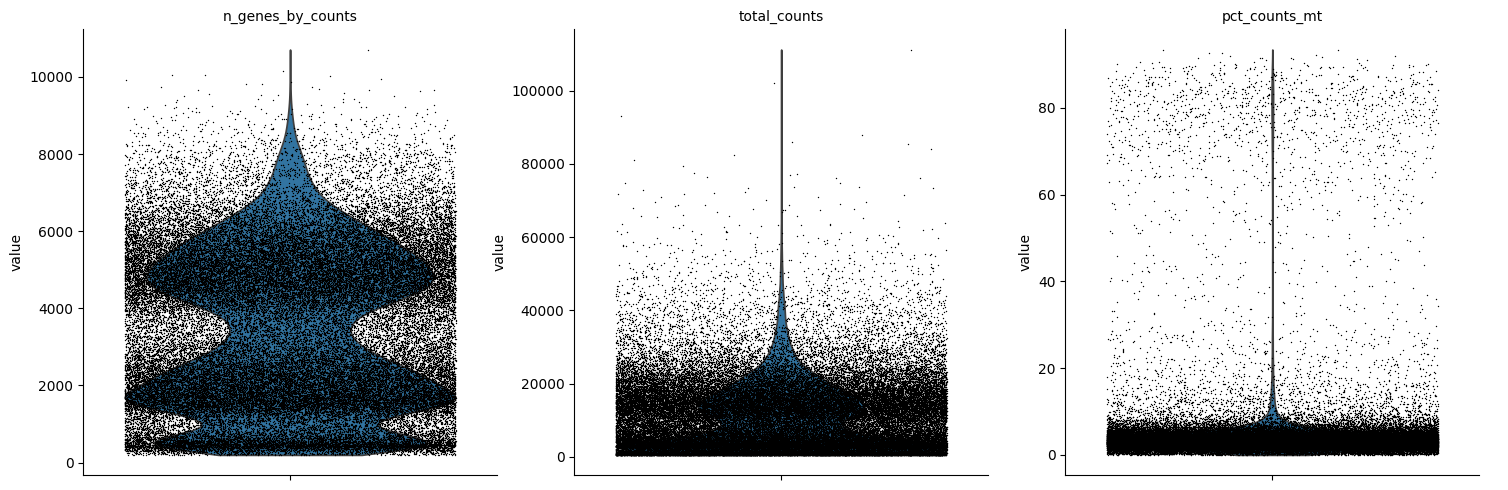

In [2]:
# 标记线粒体基因
adata_combined.var['mt'] = adata_combined.var_names.str.startswith('MT-')
# 计算质控指标
sc.pp.calculate_qc_metrics(adata_combined, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# 过滤细胞和基因：至少检测到200个基因的细胞，至少3个细胞中表达的基因
sc.pp.filter_cells(adata_combined, min_genes=200)
sc.pp.filter_genes(adata_combined, min_cells=3)

# 可视化质控指标
sc.pl.violin(adata_combined, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)

# 根据质控指标过滤细胞（示例阈值，需根据实际数据调整）
adata_combined = adata_combined[adata_combined.obs.n_genes_by_counts < 2500, :]  # 去除基因数过多的细胞（可能为双细胞）
adata_combined = adata_combined[adata_combined.obs.pct_counts_mt < 5, :]  # 去除线粒体基因占比过高的细胞（可能为死细胞）

In [3]:
sc.pp.normalize_total(adata_combined)
sc.pp.log1p(adata_combined)
sc.pp.highly_variable_genes(adata_combined)
adata_combined = adata_combined[:, adata_combined.var.highly_variable]

sc.pp.scale(adata_combined, max_value=10)

c:\Users\gjr20\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\gjr20\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [3]:
# 1. 归一化
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)

# 2. 高变基因选择
sc.pp.highly_variable_genes(adata_combined, flavor="seurat_v3", n_top_genes=2000, batch_key="batch")

# 3. 仅保留高变基因
adata_combined = adata_combined[:, adata_combined.var.highly_variable]
'''
# 4. 去批次效应（可选）
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.external.pp.harmony_integrate(adata_combined, key='batch')  # 如果安装了 harmony'''


c:\Users\gjr20\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\gjr20\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


"\n# 4. 去批次效应（可选）\nsc.pp.scale(adata_combined, max_value=10)\nsc.tl.pca(adata_combined, svd_solver='arpack')\nsc.external.pp.harmony_integrate(adata_combined, key='batch')  # 如果安装了 harmony"

In [4]:
import scanpy as sc

# PCA 降维
sc.tl.pca(adata_combined, svd_solver='arpack')

# 构建邻居图
sc.pp.neighbors(adata_combined, n_neighbors=15, n_pcs=30)
'''
# 尝试不同分辨率聚类
for res in [0.3, 0.6, 1.0]:
    sc.tl.leiden(adata_combined, resolution=res, key_added=f'leiden_{res}')
    print(f"Resolution {res}: {adata_combined.obs[f'leiden_{res}'].nunique()} clusters")
'''
# 可视化不同聚类结果
sc.tl.umap(adata_combined)
#sc.pl.umap(adata_combined, color=['leiden_0.3', 'leiden_0.6', 'leiden_1.0'])


c:\Users\gjr20\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\gjr20\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\gjr20\AppData\Local\Programs\Python\Python39\

In [5]:
sc.tl.leiden(adata_combined, resolution=0.5)            # 步骤3: 聚类


C:\Users\gjr20\AppData\Local\Temp\ipykernel_21160\1080311486.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=0.5)            # 步骤3: 聚类


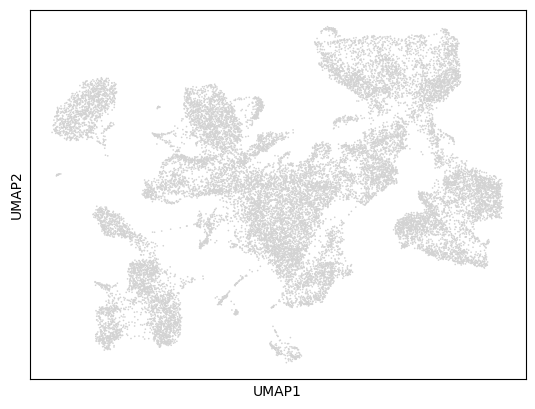

In [6]:
sc.pl.umap(adata_combined)

In [3]:
sc.pl.umap(adata_combined, color=['leiden', 'batch'])



KeyError: 'Could not find key leiden in .var_names or .obs.columns.'

<Figure size 1455.6x480 with 0 Axes>

In [ ]:
# 1. 归一化
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)

# 2. 高变基因选择
sc.pp.highly_variable_genes(adata_combined, flavor="seurat_v3", n_top_genes=2000, batch_key="batch")

# 3. 仅保留高变基因
adata_combined = adata_combined[:, adata_combined.var.highly_variable]

# 4. 去批次效应（可选）
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.external.pp.harmony_integrate(adata_combined, key='batch')  # 如果安装了 harmony

# 5. 邻居图 + 聚类 + UMAP
sc.pp.neighbors(adata_combined, use_rep="X_pca_harmony" if "X_pca_harmony" in adata_combined.obsm else "X_pca")
sc.tl.umap(adata_combined)
sc.tl.leiden(adata_combined, resolution=0.5)


c:\Users\gjr20\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
c:\Users\gjr20\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-12-03 11:35:11,031 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-12-03 11:35:32,545 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-03 11:35:33,374 - harmonypy - INFO - Iteration 1 of 10
2025-12-03 11:36:20,485 - harmonypy - INFO - Iteration 2 of 10
2025-12-03 11:37:05,995 - harmonypy - INFO - Iteration 3 of 10
2025-12-03 11:37:51,987 - harmonypy - INFO - Iteration 4 of 10
2025-12-03 11:38:35,970 - harmonypy - INFO - Iteration 5 of 10
2025-12-03 11:39:19,611 - harmonypy - INFO - Converged after 5 iterations
c:\Users\gjr

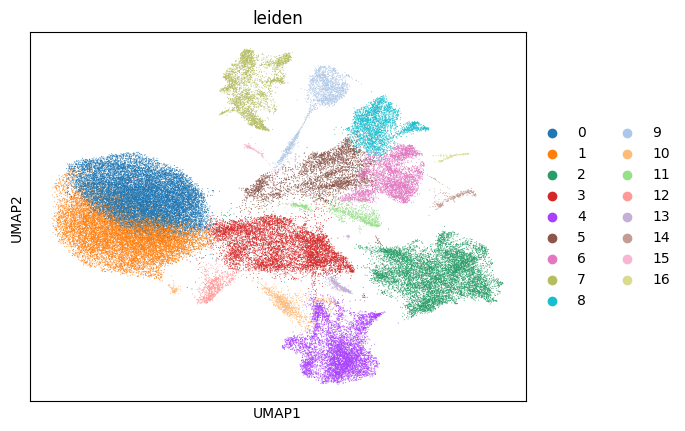

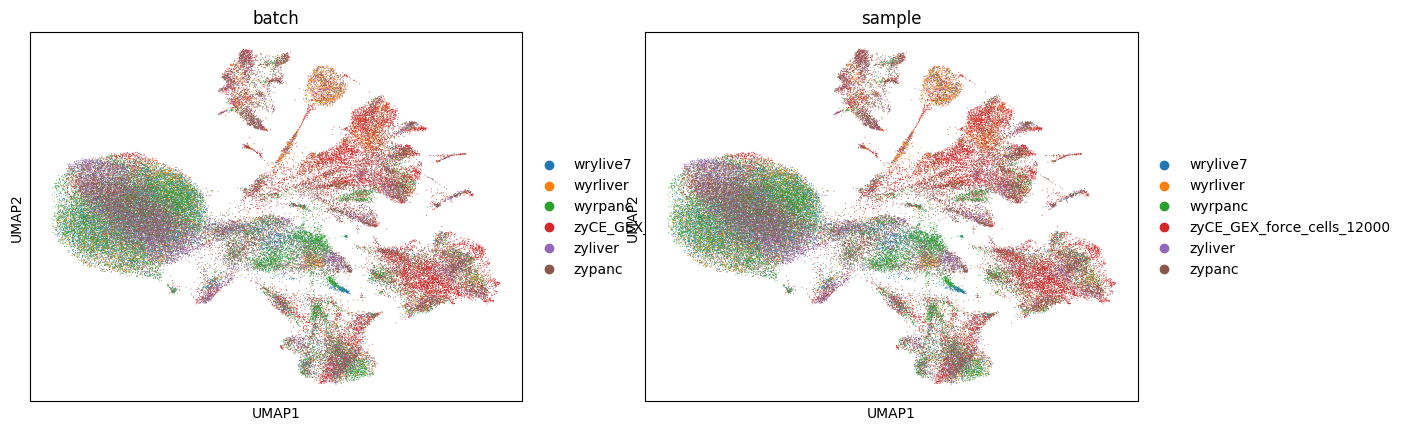

In [ ]:
# 按聚类显示
sc.pl.umap(adata_combined, color=["leiden"])

# 按样本来源显示
sc.pl.umap(adata_combined, color=["batch", "sample"])


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy import sparse, stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Optional, List

class AmbientRNARemover:
    """
    环境RNA去除算法，专门针对癌栓/血栓样本中的血小板、红系和中性粒细胞RNA污染
    """
    
    def __init__(self, 
                 ambient_percentage: float = 0.1,
                 marker_genes: Optional[dict] = None,
                 random_state: int = 42):
        """
        初始化环境RNA去除器
        
        参数:
        ambient_percentage: 要去除的环境RNA百分比 (5-15%)
        marker_genes: 特定细胞类型的标记基因字典
        random_state: 随机种子
        """
        self.ambient_percentage = ambient_percentage
        self.random_state = random_state
        np.random.seed(random_state)
        
        # 默认的污染标记基因
        if marker_genes is None:
            self.marker_genes = {
                'platelet': ['PF4', 'PPBP', 'ITGA2B', 'GP1BA'],
                'erythroid': ['HBA1', 'HBA2', 'HBB', 'ALAS2'],
                'neutrophil': ['CXCL8', 'FCGR3B', 'CSF3R', 'S100A8', 'S100A9'],
                'general_ambient': ['MALAT1', 'B2M', 'ACTB', 'GAPDH']
            }
        else:
            self.marker_genes = marker_genes
            
    def estimate_ambient_profile(self, adata: ad.AnnData) -> np.ndarray:
        """
        估计环境RNA表达谱
        
        基于谱减法原理[1](@ref)[2](@ref)，通过识别低质量细胞来估计环境RNA背景
        """
        print("估计环境RNA表达谱...")
        
        # 计算细胞质量指标
        sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
        
        # 识别低质量细胞作为环境RNA的估计源
        # 使用总UMI数、基因数和线粒体基因比例
        n_counts = adata.obs['total_counts'].values
        n_genes = adata.obs['n_genes_by_counts'].values
        
        # 识别可能的空滴或低质量细胞（环境RNA主要来源）
        if 'pct_counts_mt' in adata.obs.columns:
            mt_percent = adata.obs['pct_counts_mt'].values
            # 综合质量评分
            quality_score = (n_counts / np.median(n_counts)) * \
                           (n_genes / np.median(n_genes)) * \
                           (1 - mt_percent / 100)
        else:
            quality_score = (n_counts / np.median(n_counts)) * \
                           (n_genes / np.median(n_genes))
        
        # 选择质量最低的细胞作为环境RNA估计
        n_ambient_cells = max(10, int(adata.n_obs * 0.05))  # 至少10个细胞，最多5%
        ambient_idx = np.argsort(quality_score)[:n_ambient_cells]
        
        # 计算环境RNA表达谱（这些细胞的平均表达）
        if sparse.issparse(adata.X):
            ambient_profile = adata.X[ambient_idx, :].mean(axis=0).A1
        else:
            ambient_profile = adata.X[ambient_idx, :].mean(axis=0)
        
        # 增强特定污染基因的信号
        for cell_type, genes in self.marker_genes.items():
            gene_indices = []
            for gene in genes:
                if gene in adata.var_names:
                    idx = np.where(adata.var_names == gene)
                    if len(idx) > 0:
                        gene_indices.append(idx
            
            if len(gene_indices) > 0:
                # 增加这些标记基因的权重
                weight_factor = 2.0 if cell_type in ['platelet', 'erythroid', 'neutrophil'] else 1.5
                ambient_profile[gene_indices] *= weight_factor
        
        return ambient_profile
    
    def spectral_subtraction(self, 
                           adata: ad.AnnData, 
                           ambient_profile: np.ndarray) -> ad.AnnData:
        """
        执行谱减法去除环境RNA
        
        借鉴语音去噪中的谱减法思想[1](@ref)[2](@ref)，从观测信号中减去估计的环境RNA
        """
        print(f"执行谱减法去除{self.ambient_percentage*100:.1f}%环境RNA...")
        
        # 创建数据的副本
        adata_clean = adata.copy()
        
        if sparse.issparse(adata.X):
            X_dense = adata.X.toarray()
        else:
            X_dense = adata.X.copy()
        
        # 归一化环境RNA谱
        ambient_norm = ambient_profile / (ambient_profile.sum() + 1e-10)
        
        # 对每个细胞计算环境RNA贡献
        n_cells = X_dense.shape
        cleaned_data = np.zeros_like(X_dense)
        
        for i in range(n_cells):
            cell_counts = X_dense[i, :]
            total_counts = cell_counts.sum()
            
            # 估计该细胞的环境RNA贡献
            ambient_contribution = total_counts * self.ambient_percentage * ambient_norm
            
            # 执行谱减法：从观测值中减去估计的环境RNA
            cleaned_counts = cell_counts - ambient_contribution
            
            # 应用非负约束（类似于语音去噪中的处理[2](@ref)）
            cleaned_counts[cleaned_counts < 0] = 0
            
            # 保持总UMI数不变（重新标准化）
            if cleaned_counts.sum() > 0:
                scaling_factor = total_counts / cleaned_counts.sum()
                cleaned_counts = cleaned_counts * scaling_factor
            
            cleaned_data[i, :] = cleaned_counts
        
        # 更新数据
        if sparse.issparse(adata.X):
            adata_clean.X = sparse.csr_matrix(cleaned_data)
        else:
            adata_clean.X = cleaned_data
        
        return adata_clean
    
    def two_step_clustering(self, adata: ad.AnnData) -> Tuple[np.ndarray, np.ndarray]:
        """
        双TS（Two-step）聚类分析
        
        第一步：基于高变基因的粗聚类
        第二步：基于去噪后数据的精细聚类
        """
        print("执行双TS聚类分析...")
        
        # 第一步：基于高变基因的初步聚类
        sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
        adata_hvg = adata[:, adata.var['highly_variable']].copy()
        
        # 标准化和PCA
        sc.pp.scale(adata_hvg, max_value=10)
        sc.tl.pca(adata_hvg, n_comps=50, random_state=self.random_state)
        
        # 邻居图和粗聚类
        sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=30, random_state=self.random_state)
        sc.tl.leiden(adata_hvg, resolution=0.8, random_state=self.random_state)
        coarse_clusters = adata_hvg.obs['leiden'].astype(int).values
        
        # 第二步：基于完整数据的精细聚类
        sc.pp.scale(adata, max_value=10)
        sc.tl.pca(adata, n_comps=30, random_state=self.random_state)
        sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20, random_state=self.random_state)
        sc.tl.leiden(adata, resolution=1.2, random_state=self.random_state)
        fine_clusters = adata.obs['leiden'].astype(int).values
        
        return coarse_clusters, fine_clusters
    
    def detect_cnv_signatures(self, 
                            adata: ad.AnnData, 
                            reference_cells: Optional[np.ndarray] = None) -> pd.DataFrame:
        """
        检测CNV（拷贝数变异）信号
        
        参考中性粒细胞研究中使用的分析方法[8](@ref)
        """
        print("检测CNV信号...")
        
        # 如果没有提供参考细胞，使用所有细胞的平均值作为参考
        if reference_cells is None:
            if sparse.issparse(adata.X):
                reference_profile = adata.X.mean(axis=0).A1
            else:
                reference_profile = adata.X.mean(axis=0)
        else:
            if sparse.issparse(adata.X):
                reference_profile = adata.X[reference_cells, :].mean(axis=0).A1
            else:
                reference_profile = adata.X[reference_cells, :].mean(axis=0)
        
        # 计算每个细胞的CNV得分
        cnv_scores = []
        n_cells = adata.n_obs
        
        for i in range(n_cells):
            if sparse.issparse(adata.X):
                cell_profile = adata.X[i, :].toarray().flatten()
            else:
                cell_profile = adata.X[i, :]
            
            # 计算与参考的差异（类似log2 fold change）
            with np.errstate(divide='ignore', invalid='ignore'):
                log2fc = np.log2((cell_profile + 1) / (reference_profile + 1))
                log2fc = np.nan_to_num(log2fc, nan=0.0, posinf=0.0, neginf=0.0)
            
            # 使用滑动窗口平滑CNV信号
            window_size = 20
            smoothed_cnv = np.convolve(log2fc, np.ones(window_size)/window_size, mode='same')
            
            # 计算CNV得分（异常值的幅度）
            cnv_score = np.mean(np.abs(smoothed_cnv[smoothed_cnv > 1.5]))
            cnv_scores.append(cnv_score)
        
        # 创建CNV结果DataFrame
        cnv_results = pd.DataFrame({
            'cell_index': range(n_cells),
            'cnv_score': cnv_scores,
            'has_cnv_amplification': [score > 0.5 for score in cnv_scores],
            'has_cnv_deletion': [score < -0.5 for score in cnv_scores]
        })
        
        return cnv_results
    
    def visualize_results(self, 
                        """
        可视化去噪前后的对比结果
        """
        print("生成可视化结果...")
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # 1. 环境RNA标记基因表达对比
        ax = axes[0, 0]
        marker_genes_to_plot = ['PF4', 'PPBP', 'HBA1', 'HBB', 'CXCL8']
        available_genes = [g for g in marker_genes_to_plot if g in adata_original.var_names]
        
        if available_genes:
            original_expr = adata_original[:, available_genes].X.mean(axis=0)
            cleaned_expr = adata_cleaned[:, available_genes].X.mean(axis=0)
            
            x = np.arange(len(available_genes))
            width = 0.35
            
            ax.bar(x - width/2, original_expr, width, label='原始数据', alpha=0.8)
            ax.bar(x + width/2, cleaned_expr, width, label='去噪后', alpha=0.8)
            ax.set_xticks(x)
            ax.set_xticklabels(available_genes, rotation=45)
            ax.set_ylabel('平均表达量')
            ax.set_title('环境RNA标记基因表达对比')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 2. 总UMI数分布对比
        ax = axes[0, 1]
        original_totals = adata_original.X.sum(axis=1).A1 if sparse.issparse(adata_original.X) else adata_original.X.sum(axis=1)
        cleaned_totals = adata_cleaned.X.sum(axis=1).A1 if sparse.issparse(adata_cleaned.X) else adata_cleaned.X.sum(axis=1)
        
        ax.hist(original_totals, bins=50, alpha=0.5, label='原始数据', density=True)
        ax.hist(cleaned_totals, bins=50, alpha=0.5, label='去噪后', density=True)
        ax.set_xlabel('总UMI数')
        ax.set_ylabel('密度')
        ax.set_title('UMI分布对比')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. 检测到的基因数对比
        ax = axes[0, 2]
        original_ngenes = (adata_original.X > 0).sum(axis=1).A1 if sparse.issparse(adata_original.X) else (adata_original.X > 0).sum(axis=1)
        cleaned_ngenes = (adata_cleaned.X > 0).sum(axis=1).A1 if sparse.issparse(adata_cleaned.X) else (adata_cleaned.X > 0).sum(axis=1)
        
        ax.scatter(original_ngenes, cleaned_ngenes, alpha=0.5, s=10)
        ax.plot([0, max(original_ngenes)], [0, max(original_ngenes)], 'r--', alpha=0.5)
        ax.set_xlabel('原始数据基因数')
        ax.set_ylabel('去噪后基因数')
        ax.set_title('检测基因数对比')
        ax.grid(True, alpha=0.3)
        
        # 4. CNV得分分布
        ax = axes[1, 0]
        ax.hist(cnv_results['cnv_score'], bins=50, alpha=0.7, color='purple')
        ax.axvline(x=0.5, color='r', linestyle='--', alpha=0.7, label='CNV阈值')
        ax.set_xlabel('CNV得分')
        ax.set_ylabel('细胞数')
        ax.set_title('CNV得分分布')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 5. PCA可视化对比
        ax = axes[1, 1]
        # 对去噪后数据计算PCA
        sc.pp.scale(adata_cleaned)
        sc.tl.pca(adata_cleaned, n_comps=2, random_state=self.random_state)
        
        if 'cnv_score' in cnv_results.columns:
            scatter = ax.scatter(adata_cleaned.obsm['X_pca'][:, 0],
                               adata_cleaned.obsm['X_pca'][:, 1],
                               c=cnv_results['cnv_score'],
                               cmap='viridis',
                               alpha=0.6,
                               s=20)
            plt.colorbar(scatter, ax=ax, label='CNV得分')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title('去噪后数据PCA（按CNV着色）')
        ax.grid(True, alpha=0.3)
        
        # 6. 细胞类型特异性标记基因热图
        ax = axes[1, 2]
        # 这里可以添加热图显示不同细胞类型的标记基因表达
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"可视化结果已保存至: {save_path}")
        
        plt.show()
    
    def run_pipeline(self, 
                    adata: ad.AnnData,
                    visualize: bool = True,
                    save_path: Optional[str] = None) -> Tuple[ad.AnnData, pd.DataFrame]:
        """
        运行完整的环境RNA去除流程
        """
        print("="*60)
        print("开始环境RNA去除流程")
        print(f"输入数据: {adata.n_obs} 细胞, {adata.n_vars} 基因")
        print(f"环境RNA去除比例: {self.ambient_percentage*100:.1f}%")
        print("="*60)
        
        # 1. 估计环境RNA谱
        ambient_profile = self.estimate_ambient_profile(adata)
        
        # 2. 执行谱减法去噪
        adata_cleaned = self.spectral_subtraction(adata, ambient_profile)
        
        # 3. 双TS聚类分析
        coarse_clusters, fine_clusters = self.two_step_clustering(adata_cleaned)
        adata_cleaned.obs['coarse_cluster'] = coarse_clusters.astype(str)
        adata_cleaned.obs['fine_cluster'] = fine_clusters.astype(str)
        
        # 4. CNV分析
        # 使用粗聚类的结果作为参考细胞（假设最大的簇是正常细胞）
        cluster_counts = adata_cleaned.obs['coarse_cluster'].value_counts()
        largest_cluster = cluster_counts.index
        reference_cells = adata_cleaned.obs['coarse_cluster'] == largest_cluster
        
        cnv_results = self.detect_cnv_signatures(adata_cleaned, reference_cells.values)
        
        # 5. 可视化（可选）
        if visualize:
            self.visualize_results(adata, adata_cleaned, cnv_results, save_path)
        
        print("="*60)
        print("环境RNA去除流程完成")
        print(f"CNV异常细胞比例: {(cnv_results['cnv_score'] > 0.5).mean()*100:.2f}%")
        print("="*60)
        
        return adata_cleaned, cnv_results


# 使用示例
def main():
    """
    主函数：演示如何使用环境RNA去除算法
    """
    # 假设你已经有一个AnnData对象
    # adata = sc.read_h5ad('your_data.h5ad')
    
    # 创建示例数据（实际使用时请替换为你的数据）
    print("创建示例数据...")
    n_cells = 1000
    n_genes = 2000
    
    # 模拟表达矩阵
    np.random.seed(42)
    base_expression = np.random.negative_binomial(10, 0.1, size=(n_cells, n_genes))
    
    # 添加环境RNA污染
    ambient_genes = ['PF4', 'PPBP', 'HBA1', 'HBB', 'CXCL8', 'MALAT1', 'B2M']
    gene_names = [f'Gene_{i}' for i in range(n_genes)]
    # 在实际数据中，这些基因应该有真实的名称
    
    # 创建AnnData对象
    adata = ad.AnnData(
        X=base_expression,
        obs=pd.DataFrame(index=[f'Cell_{i}' for i in range(n_cells)]),
        var=pd.DataFrame(index=gene_names)
    )
    
    # 初始化去除器
    remover = AmbientRNARemover(
        ambient_percentage=0.1,  # 去除10%的环境RNA
        random_state=42
    )
    
    # 运行完整流程
    adata_cleaned, cnv_results = remover.run_pipeline(
        adata=adata,
        visualize=True,
        save_path='ambient_rna_removal_results.png'
    )
    
    # 保存处理后的数据
    adata_cleaned.write('cleaned_data.h5ad')
    cnv_results.to_csv('cnv_analysis_results.csv', index=False)
    
    print("处理完成！")
    print(f"原始数据形状: {adata.shape}")
    print(f"去噪后数据形状: {adata_cleaned.shape}")
    print(f"CNV分析结果已保存至: cnv_analysis_results.csv")


if __name__ == "__main__":
    main()
         adata_original: ad.AnnData,
                         adata_cleaned: ad.AnnData,
                         cnv_results: pd.DataFrame,
                         save_path: Optional[str] = None):
